In [91]:
from Functions import *
import pyautogui 
import matplotlib.pyplot as plt
import itertools

In [2]:
# get the data
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names)
im=df['pixels']
df.head(10)
imbalancedf = df[df['emotion']!='emotion']
im=imbalancedf.emotion.apply(lambda x: ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][int(x)])
labeleddf = pd.DataFrame()
labeleddf['pixels']=df['pixels']




In [3]:
labeleddf['emotion'] = im

In [5]:
labeleddf = labeleddf.iloc[1:]

In [131]:
labeleddf.head(15)

,pixels,emotion
1,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Anger
2,151 150 147 155 148 133 111 140 170 174 182 15...,Anger
3,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral
6,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Fear
7,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Sad
8,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Happy
9,85 84 90 121 101 102 133 153 153 169 177 189 1...,Happy
10,255 254 255 254 254 179 122 107 95 124 149 150...,Fear


In [10]:
def picfromdf(df,index):
    arr = df['pixels'].iloc[index]
    arr = arr.split(' ')
    ans = []
    for i in arr:
        ans.append(int(i))
    plt.matshow(np.array(ans).reshape(48,48),cmap='gray')
    plt.title(df['emotion'].iloc[index])
    return np.array(ans).reshape(48,48)
def genpicdict(df):
    picdict = {}
    for i in ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']:
        if i not in picdict:
            picdict[i] = picfromdf(df[df['emotion'] == i],1)
    return picdict
def modelpredictonpicdict(picdict,model):
    picpixels = []
    for i in picdict.keys():
        picpixels.append(picdict[i])
    picpixels = np.array(picpixels)
    picpixels = picpixels.reshape(len(picdict.keys()),48,48,1)
    predictions = model.predict(picpixels)
    ans = []
    for a in predictions:
        ans.append(['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][int(a.argmax())])
    print(ans)
def makeexplanaitionmodel(model):
    layer_outputs = [layer.output for layer in model.layers[:9]] 
# Extracts the outputs of the top 12 layers
    activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
    return activation_model
def explanationpic(picdict):
    picpixels = []
    picid = []
    origpic = []
    for i in picdict.keys():
        origpic.append(picdict[i])
        picid.append(i)
        picpixels.append(picdict[i])
    picpixels = np.array(picpixels)
    picpixels = picpixels.reshape(len(picdict.keys()),48,48,1)
    predictions = emodel.predict(picpixels)
    print(predictions.shape)
#     for i in predictions[0]:
#         plt.matshow(i.reshape(-1,9,48,48,1),cmap='gray')
#         plt.title(i)
    return picid,origpic,predictions

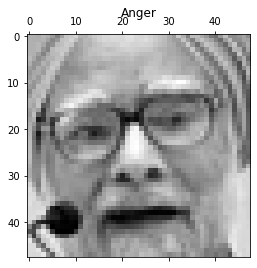

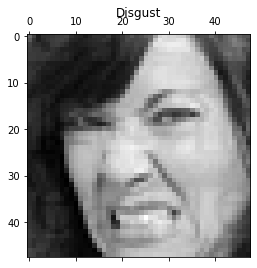

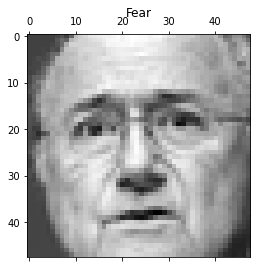

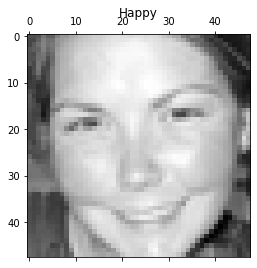

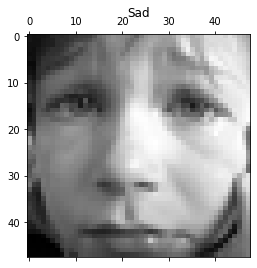

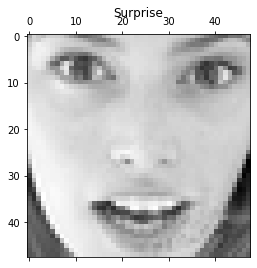

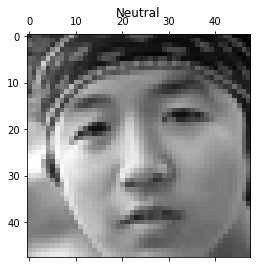

In [6]:
picdict = genpicdict(labeleddf)

In [9]:
modelpredictonpicdict(picdict,model)


['Fear', 'Disgust', 'Neutral', 'Neutral', 'Surprise', 'Surprise', 'Neutral']


In [53]:

for i in picdict.keys():
    plt.matshow(emodel.predict(picdict[i].reshape(1,48,48,1)),cmap='gray')
    plt.title(i)

ValueError: could not broadcast input array from shape (48,48,64) into shape (1)

In [13]:
# for x in range(64):
ids,originals,preds = explanationpic(picdict)
# plt.matshow(explanationpic(picdict)[1][4,:,:,0],cmap='gray')
for picnum in range(3):
    plt.matshow(originals[picnum],cmap='gray')
    plt.title(ids[picnum])
    for layer in range(5):
        for fil in range(len(preds[layer][picnum,1,1,:])):
            plt.matshow(preds[layer][picnum,:,:,fil],cmap='gray')
            plt.title(f'pic:{picnum},layer:{layer},filnum{fil}')

AttributeError: 'list' object has no attribute 'shape'

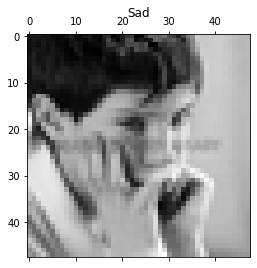

In [160]:
x = picfromdf(labeleddf,3)


In [12]:
emodel = makeexplanaitionmodel(model)


Text(0.5, 1.0, 'Class imbalance')

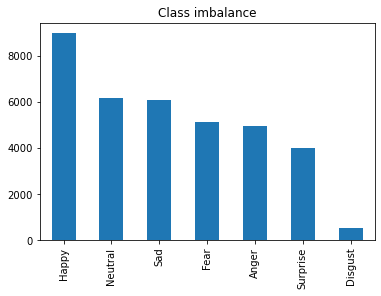

In [64]:
im.value_counts().plot.bar()
plt.title('Class imbalance')


In [31]:
im.value_counts()

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Anger       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64

In [22]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [23]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)
cascade = load_cascade_classifier_xml()
print(X.shape)

(35887, 48, 48, 1)


In [24]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [89]:
path_model='model_filter.h5' # save model at this location after each epoch
model=my_model() # create the model
model.load_weights(path_model)
# fit the model
# h=model.fit(x=X_train,     
#             y=y_train, 
#             batch_size=64, 
#             epochs=20, 
#             verbose=1, 
#             validation_data=(X_test,y_test),
#             shuffle=True,
#             callbacks=[
#                 ModelCheckpoint(filepath=path_model),
#             ]
#             )

In [26]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [90]:
y_pred=model.predict(X_test)
y_test.shape


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2020-11-11 17:26:10,654 WARNING From /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


(3589, 7)

In [28]:

ly_pred = []
for i in y_pred:
    ly_pred.append(i.argmax())
ly_test = []
for i in y_test:
    ly_test.append(i.argmax())

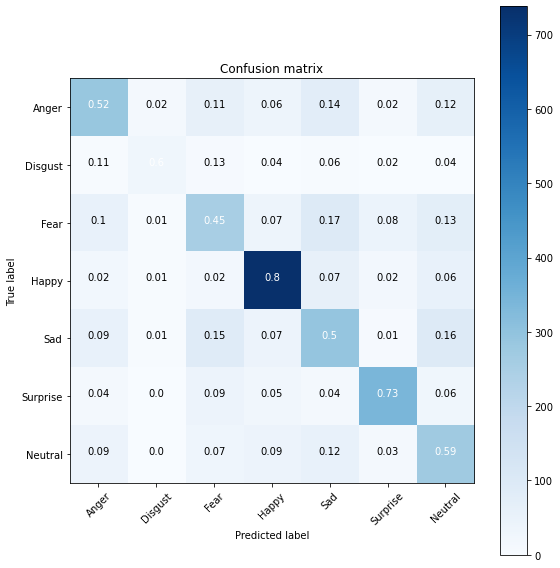

In [71]:
from sklearn.metrics import confusion_matrix

cm = tf.math.confusion_matrix(ly_pred,ly_test)
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    cm = np.array(cm)
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure
cm =plot_confusion_matrix(cm,label_map)

In [46]:

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")
sfps = 0
  
fps = 0
while True:
    ret, frame = cap.read()
    baseframe = frame
    

    #logger.debug('postprocess+')
    
    coords,faces,faceframe = find_faces_in_img(frame,cascade)
    if len(faces) < 1:
        fps=time()
        FPS=1/(fps-sfps)
        sfps = fps 

        FPS = 'FPS:'+str(round(FPS,ndigits=3))
        maketextaboveface(baseframe,FPS,(10,70))
        cv2.imshow('feed', baseframe)
        
        c = cv2.waitKey(1)
        if c == 27:
            break

        continue
    for i in range(0,len(faces)):
        face = faces[i]
        frame = prep_image(face)

        prediction = predict_emotion(frame,model)

        text = 'Prediction = '+str(prediction)
        maketextaboveface(baseframe,text,(coords[i][2],coords[i][0]))
#     humans = e.inference(baseframe,
#                          resize_to_default=(w > 0 and h > 0),
#                          upsample_size=resize_out_ratio)
#     image = TfPoseEstimator.draw_humans(baseframe, humans, imgcopy=False)
    fps=time()
    FPS=1/(fps-sfps)
    sfps = fps
    FPS = 'FPS:'+str(round(FPS,ndigits=3))+' & We Found '+str(len(faces))+ ' Face(s)!'
    maketextaboveface(baseframe,FPS,(10,70))
    cv2.imshow('feed', baseframe)
    
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()


In [86]:
import sys
import time
import logging
import numpy as np
import cv2

from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

logger = logging.getLogger('TfPoseEstimator-WebCam')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
camera = 0
resize = '432x368'     # resize images before they are processed
resize_out_ratio = 4.0 # resize heatmaps before they are post-processed
model = 'mobilenet_thin'
show_process = False
tensorrt = False       # for tensorrt process
# logger.debug('initialization %s : %s' % (args.model, get_graph_path(args.model)))
w, h = model_wh(resize)
if w > 0 and h > 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368), trt_bool=False)
# humans = e.inference(image,
#                          resize_to_default=(w > 0 and h > 0),
#                          upsample_size=resize_out_ratio)

#     #logger.debug('postprocess+')
#     image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
from IPython.display import clear_output
clear_output()

In [ ]:

sfps = 0
  
fps = 0
while True:
    img = pyautogui.screenshot()
    frame = np.array(img)[1500:,900:]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    baseframe = frame

#     humans = e.inference(baseframe,
#                           resize_to_default=(w > 0 and h > 0),
#                           upsample_size=resize_out_ratio)

#     image = TfPoseEstimator.draw_humans(baseframe, humans, imgcopy=False)
    coords,faces,faceframe = find_faces_in_img(frame,cascade)
    if len(faces) < 1:
        fps=time()
        FPS=1/(fps-sfps)
        sfps = fps 

        FPS = 'FPS:'+str(round(FPS,ndigits=3))
        maketextaboveface(baseframe,FPS,(10,70))
        cv2.imshow('feed', baseframe)
        
        c = cv2.waitKey(1)
        if c == 27:
            break

        continue
    for i in range(0,len(faces)):
        face = faces[i]
        frame = prep_image(face)

        prediction = predict_emotion(frame,model)

        text = 'Prediction = '+str(prediction)
        maketextaboveface(baseframe,text,(coords[i][2],coords[i][0]))
    fps=time()
    FPS=1/(fps-sfps)
    sfps = fps
    FPS = 'FPS:'+str(round(FPS,ndigits=3))+' & We Found '+str(len(faces))+ ' Face(s)!'
    maketextaboveface(baseframe,FPS,(10,70))
    cv2.imshow('feed', baseframe)
    
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [16]:
pyautogui.position()

Point(x=1246, y=954)

In [134]:

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")
sfps = 0
  
fps = 0
while True:
    ret, frame = cap.read()
    baseframe = frame
#     humans = e.inference(baseframe,
#                          resize_to_default=(w > 0 and h > 0),
#                          upsample_size=resize_out_ratio)

    #logger.debug('postprocess+')
#     image = TfPoseEstimator.draw_humans(baseframe, humans, imgcopy=False)
    coords,faces,faceframe = find_faces_in_img(frame,cascade)
    
        
        
    for i in range(0,len(faces)):
        face = faces[i]
        frame = prep_image(face)

        prediction = predict_emotion(frame,model)

        text = 'Prediction = '+str(prediction)
        maketextaboveface(baseframe,text,(coords[i][1],coords[i][0]))
    fps=time()
    FPS=1/(fps-sfps)
    sfps = fps
    FPS = 'FPS:'+str(round(FPS,ndigits=3))+' & We Found '+str(len(faces))+ ' Face(s)!'
    maketextaboveface(baseframe,FPS,(10,70))
    cv2.imshow('feed', baseframe)
    
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

NameError: name 'cascade' is not defined

In [15]:
def deprocess(img):
    return tf.cast(img, tf.float32)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(tf.cast(img, tf.uint8))))
# Create the feature extraction model
    
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),))
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
                gradients = tape.gradient(loss, img)

        # Normalize the gradients.
                gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
                img = img + gradients*step_size
#                 img = tf.clip_by_value(img, -1, 1)

        return loss, img
def run_deep_dream_simple(img, steps=100, step_size=0.01):
      # Convert from uint8 to the range expected by the model.
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
    
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
        display.clear_output(wait=True)
        show(img)
        print ("Step {}, loss {}".format(step, loss))


        result = img
        display.clear_output(wait=True)
        show(result)

    return result
def generatedeepdreamimg(imagebatch,model,imageposinbatch):
    base_model = model

    names = [name.name for name in  base_model.layers]
    layers = [base_model.get_layer(name).output for name in names[:]]

# Create the feature extraction model
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

    original_img = np.array(imagebatch)
    original_img = original_img[imageposinbatch]
    original_img = ((original_img)).astype(np.float32)
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# show(deprocess(original_img))
    deepdream = DeepDream(dream_model)
    dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=1000, step_size=0.5)
    return dream_img

In [40]:
base_model = model

names = [name.name for name in  base_model.layers]
layers = [base_model.get_layer(name).output for name in names[:]]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
# coords,faces,faceframe = find_faces_in_img(frame,cascade)
face = faces[0]
frame = prep_image(face)
pickedpic= frame

# deepdream = DeepDream(dream_model)
# dream_img = run_deep_dream_simple(img=pickedpic, 
#                                   steps=1000, step_size=0.5)


In [98]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")
sfps = 0
  
fps = 0
pics = []
while True:
    ret, frame = cap.read()
    baseframe = frame
    

    #logger.debug('postprocess+')
    
    coords,faces,faceframe = find_faces_in_img(frame,cascade)
    
#     for i in range(0,len(faces)):
#         face = faces[i]
#         frame = prep_image(face)

#         prediction = predict_emotion(frame,model)

#         text = 'Prediction = '+str(prediction)
#         maketextaboveface(baseframe,text,(coords[i][2],coords[i][0]))
#     humans = e.inference(baseframe,
#                          resize_to_default=(w > 0 and h > 0),
#                          upsample_size=resize_out_ratio)
#     image = TfPoseEstimator.draw_humans(baseframe, humans, imgcopy=False)
#     fps=time()
#     FPS=1/(fps-sfps)
#     sfps = fps
#     FPS = 'FPS:'+str(round(FPS,ndigits=3))+' & We Found '+str(len(faces))+ ' Face(s)!'
#     maketextaboveface(baseframe,FPS,(10,70))

    cv2.imshow('feed', baseframe)
    
    c = cv2.waitKey(33)
    if c == 32:
        coords,faces,faceframe = find_faces_in_img(baseframe,cascade)

        for i in range(0,len(faces)):
            
            face = faces[i]
            frame = prep_image(face)

            prediction = predict_emotion(frame,model)

            text = 'Prediction = '+str(prediction)
            maketextaboveface(baseframe,text,(coords[i][2],coords[i][0]))
            cv2.imshow(f'face{i}', face)
            pics.append(face)
    elif c == 27:
        break
cap.release()
cv2.destroyAllWindows()


In [99]:
myface = prep_image(face)

In [100]:
import pickle as pkl
pkl.dump(myface,open('myface.pkl','wb'))